# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [49]:
# Import necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from collections import Counter
import string

# Import for NLP tasks
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Import for transformers (e.g., for using NLP models)
from transformers import pipeline

# Import for generating word clouds
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 39
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews
Scraping page 16
   ---> 1600 total reviews
Scraping page 17
   ---> 1700 total reviews
Scraping page 18
   ---> 1800 total reviews
Scraping page 19
   ---> 1900 total reviews
Scraping page 20
   ---> 2000 total reviews
Scraping page 21
   ---> 2100 total reviews
Scraping page 22
   ---> 2200 total reviews
Scraping page 23
   ---> 2300 total reviews
Scrapi

In [28]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,Not Verified | A nightmare journey courtesy o...
1,✅ Trip Verified | Absolutely atrocious. LHR-OR...
2,✅ Trip Verified | As someone who flies relentl...
3,✅ Trip Verified | Flew with British Airways ...
4,✅ Trip Verified | Straightforward check in T...


In [15]:
df.to_csv("BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857 entries, 0 to 3856
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Trip Verified  3857 non-null   object
 1   Review         3857 non-null   object
dtypes: object(2)
memory usage: 60.4+ KB


In [29]:
# Function to extract verification status
def extract_verification_status(review):
    if '✅ Trip Verified' in review:
        return 'Yes'
    elif 'Not Verified' in review:
        return 'No'
    else:
        return 'Unknown'  # In case neither is found, or you can choose to return None

# Function to clean up reviews
def clean_review(review):
    if '✅ Trip Verified | ' in review:
        return review.replace('✅ Trip Verified | ', '')
    elif '✅ Verified Review | ' in review:
        return review.replace('✅ Verified Review | ', '')
    elif 'Not Verified | ' in review:
        return review.replace('Not Verified | ', '')
    else:
        return review

# Apply functions to create new columns
df['Trip Verified'] = df['reviews'].apply(extract_verification_status)
df['Review'] = df['reviews'].apply(clean_review)

# Optionally drop the original 'reviews' column if no longer needed
df = df.drop(columns=['reviews'])


In [35]:
df.sample(5)

,Trip Verified,Review
153,Yes,"Having not flown with BA for a few years, I r..."
1923,No,London Heathrow to Bangkok. First time flying...
611,Yes,Unfortunately having just flown in the new cl...
1239,Yes,I was in Prague flying British Airways back t...
1950,No,I am due to fly from Tehran to Vancouver via ...


In [33]:
df.iloc[1626]

,1626
Trip Verified,No
Review,London Heathrow to Hong Kong. A really mixed ...


In [32]:
# Replace 'Trip Verified' value 'Review' with 'Yes'
df.loc[df['Trip Verified'] == 'Review', 'Trip Verified'] = 'Yes'

# Replace 'Trip Verified' value 'Unknown' with 'No'
df.loc[df['Trip Verified'] == 'Unknown', 'Trip Verified'] = 'No'

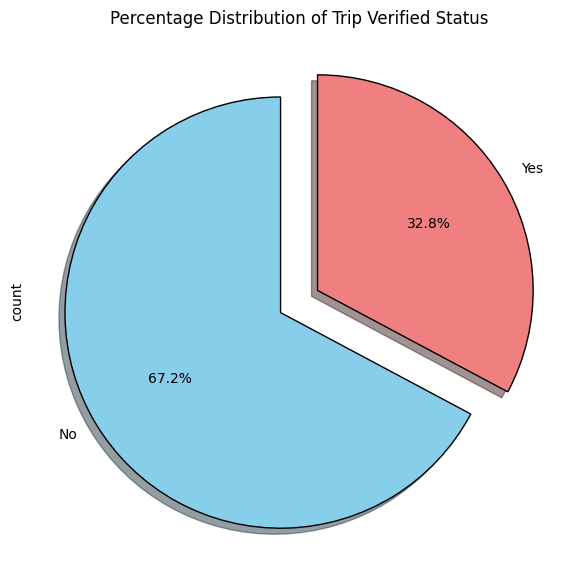

In [36]:
# Assuming df is your DataFrame
# Calculate the percentage distribution
tags = df['Trip Verified'].value_counts() / df.shape[0]

# Define the colors
colors = ('skyblue', 'lightcoral')

# Define the wedge properties
wp = {'linewidth': 1, 'edgecolor': 'black'}

# Define the explode tuple to emphasize slices
num_categories = len(tags)
explode = (0.1,) * num_categories  # Adjust explode based on number of categories

# Create a figure with a specific size
fig = plt.figure(figsize=(7, 7))

# Plot the pie chart
ax = tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode)

# Set the title of the plot
plt.title('Percentage Distribution of Trip Verified Status')

# Save the plot to a BytesIO object
graph = BytesIO()
fig.savefig(graph, format="png")

# Optionally show the plot
plt.show()


In [37]:
df.isnull().sum()

,0
Trip Verified,0
Review,0


`No Missing Values.`

### `Load the sentiment analysis pipeline`

In [41]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
classifier = pipeline("sentiment-analysis", model=model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [42]:
# Function to apply sentiment analysis with truncation
def classify_text(text):
    result = classifier(text, truncation=True) #Truncate the text to fit the model's maximum sequence length
    return result[0]['label']  # Get the sentiment label

# Apply the function to your DataFrame
df['sentiment'] = df['Review'].apply(classify_text)

In [44]:
# Save the labelled DataFrame to a new CSV file
df.to_csv('/content/BA_reviews_labelled.csv', index=False)

In [45]:
df.head(3)

,Trip Verified,Review,sentiment
0,No,A nightmare journey courtesy of British Airwa...,NEGATIVE
1,Yes,Absolutely atrocious. LHR-ORD-LHR Round-trip. ...,NEGATIVE
2,Yes,As someone who flies relentlessly with British...,NEGATIVE


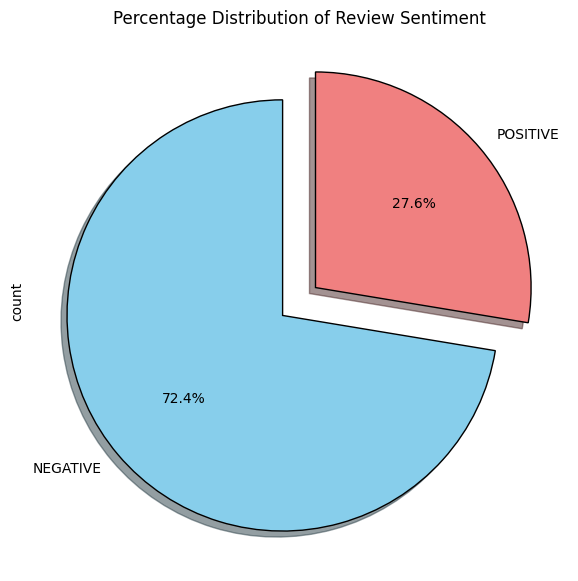

In [46]:
# Assuming df is your DataFrame
# Calculate the percentage distribution
tags = df['sentiment'].value_counts() / df.shape[0]

# Define the colors
colors = ('skyblue', 'lightcoral','green')

# Define the wedge properties
wp = {'linewidth': 1, 'edgecolor': 'black'}

# Define the explode tuple to emphasize slices
num_categories = len(tags)
explode = (0.1,) * num_categories  # Adjust explode based on number of categories

# Create a figure with a specific size
fig = plt.figure(figsize=(7, 7))

# Plot the pie chart
ax = tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode)

# Set the title of the plot
plt.title('Percentage Distribution of Review Sentiment')

# Save the plot to a BytesIO object
graph = BytesIO()
fig.savefig(graph, format="png")

# Save the plot to a file
plt.savefig('review_sentiment%.png', bbox_inches='tight')

# Optionally show the plot
plt.show()

In [47]:
def transform_text(text):
    # Convert the text to lowercase to maintain uniformity
    text = text.lower()

    # Tokenize the text into individual words
    text = nltk.word_tokenize(text)

    y = []
    # Remove any non-alphanumeric tokens (i.e., keep only words and numbers)
    for i in text:
        if i.isalnum():
            y.append(i)

    # Copy the cleaned text to a new list and clear the original list for reuse
    text = y[:]
    y.clear()

    # Remove stopwords and punctuation from the text
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    # Copy the filtered text to a new list and clear the original list for reuse
    text = y[:]
    y.clear()

    # Create an instance of PorterStemmer for stemming words
    ps = PorterStemmer()

    # Stem the words in the text (reduce them to their root form)
    for i in text:
        y.append(ps.stem(i))

    # Join the list of words back into a single string, separated by spaces
    return " ".join(y)


In [50]:
# Apply the transform_text function to the 'Review' column and store the results in a new column 'transformed_Message'
df['transformed_Message'] = df['Review'].apply(transform_text)

# Create a WordCloud instance with specified dimensions and background color
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

# Generate a word cloud for the negative sentiment messages
# This filters the DataFrame for rows with 'NEGATIVE' sentiment, concatenates the 'transformed_Message' column into a single string, and then generates the word cloud
neg_sent_wc = wc.generate(df[df['sentiment'] == 'NEGATIVE']['transformed_Message'].str.cat(sep=''))


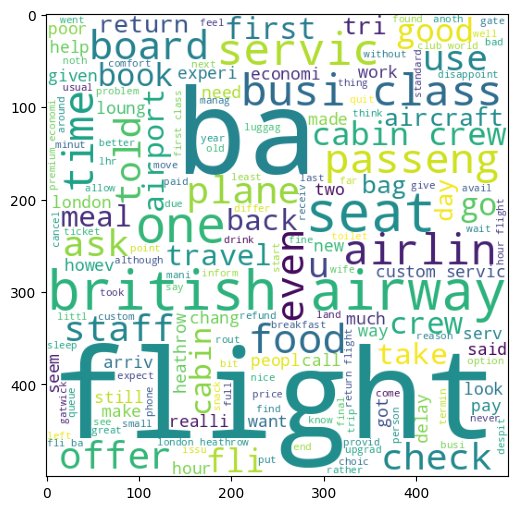

In [51]:
plt.figure(figsize=(15,6))
plt.imshow(neg_sent_wc)

# Save the plot to a file
plt.savefig('word_clouds.png', bbox_inches='tight')

In [52]:
negative_reviews = df[df['sentiment'] == 'NEGATIVE']

In [53]:
# Initialize the CountVectorizer to extract unigrams and bigrams, ignoring English stopwords
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))  # Unigrams and bigrams

# Check the available columns in the 'negative_reviews' DataFrame to ensure correct column name usage
print(negative_reviews.columns)

# Apply the CountVectorizer to the 'Review' column in the 'negative_reviews' DataFrame
# Replace 'Review' with the correct column name if necessary
X = vectorizer.fit_transform(negative_reviews['Review'])

# Get the feature names (unigrams and bigrams) generated by the vectorizer
features = vectorizer.get_feature_names_out()

# Sum the occurrences of each feature (term frequency)
frequencies = X.sum(axis=0).A1

# Create a dictionary mapping each feature to its frequency
keywords = dict(zip(features, frequencies))

# Sort the keywords by frequency in descending order
sorted_keywords = sorted(keywords.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most common unigrams and bigrams
print("Most common issues:", sorted_keywords[:10])

Index(['Trip Verified', 'Review', 'sentiment', 'transformed_Message'], dtype='object')
Most common issues: [('flight', 5380), ('ba', 4147), ('service', 2222), ('seat', 1916), ('british', 1820), ('airways', 1801), ('british airways', 1741), ('london', 1713), ('food', 1693), ('seats', 1692)]


In [54]:
# Perform topic modeling
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

# Display topics
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([features[i] for i in topic.argsort()[-10:]])


Topic 0:
['class', 'food', 'service', 'seats', 'british airways', 'airways', 'british', 'seat', 'ba', 'flight']
Topic 1:
['class', 'london', 'service', 'seat', 'seats', 'british airways', 'british', 'airways', 'ba', 'flight']
Topic 2:
['london', 'time', 'food', 'seat', 'staff', 'cabin', 'crew', 'service', 'ba', 'flight']
Topic 3:
['heathrow', 'seat', 'time', 'british airways', 'airways', 'british', 'london', 'service', 'ba', 'flight']
Topic 4:
['cabin', 'seats', 'seat', 'class', 'time', 'crew', 'food', 'business', 'ba', 'flight']
Topic 5:
['seat', 'british airways', 'airways', 'time', 'british', 'service', 'business', 'class', 'ba', 'flight']
Topic 6:
['just', 'food', 'lhr', 'crew', 'seat', 'class', 'service', 'seats', 'ba', 'flight']
Topic 7:
['time', 'good', 'london', 'cabin', 'seats', 'seat', 'food', 'service', 'flight', 'ba']
Topic 8:
['cabin', 'british airways', 'airways', 'business', 'crew', 'british', 'class', 'service', 'flight', 'ba']
Topic 9:
['seats', 'time', 'food', 'britis

**Topic 0:**



**Interpretation**: *`Focuses on "class," "food," "service," and "seats." This might reflect reviews discussing the overall in-flight experience, especially in terms of the class of service, quality of food, and seating comfort.`*



**Topic 1:**



**Interpretation**: *`Similar to Topic 0 but with an emphasis on "London." This could indicate discussions about flights to or from London, particularly focusing on service and seating.`*



**Topic 2:**





**Interpretation**: *`Combines "London," "time," and "crew," possibly highlighting the importance of punctuality and the role of the crew, especially in relation to flights connected to London.`*



**Topic 3:**



**Interpretation**: *`Mentions "Heathrow," suggesting this topic is about experiences related to London Heathrow Airport, possibly including connections, the airport environment, or BA's service there.`*


**Topic 4:**




**Interpretation**: *`Focuses on "cabin" and "business," which might relate to reviews about business class or the cabin environment in general.`*



**Topic 5:**



**Interpretation**: *`Emphasizes "business," "class," and "service," likely pointing to reviews focused on the business class experience, particularly the seating and ser`*



**Topic 6:**



**Interpretation**: *`Includes "just," "lhr," and "class," which might represent more specific or unique experiences, possibly last-minute observations, or brief comments about flights to or from Heathrow.`*



**Topic 7:**





**Interpretation**: *`Mentions "good," "london," and "cabin," suggesting positive reviews or discussions about good experiences, especially in relation to London or cabin service.`*



**Topic 8:**



**Interpretation**: *`Focuses on "business" and "crew," likely pointing to detailed discussions about the business class experience, particularly in terms of the crew's service.`*


**Topic 9:**




**Interpretation**: *`Combines "seats," "food," and "time," indicating this topic might relate to general discussions about the quality of seating, food, and punctuality on BA flights.`*

------------------------------------------------------------------------------------

------------------------------------------------------------------------------------

### General Observations:

1. **Recurring Themes:**`Across all topics, certain words frequently appear, such as "seat," "service," "food," "crew," "BA," "flight," and "British Airways." This suggests that these are the most discussed aspects of the British Airways experience.`


2. **Focus on Service Quality:** `The presence of words like "service," "crew," and "cabin" indicates that passengers often discuss the quality of service and the behavior of the crew.`


3. **Emphasis on Seats:** `The word "seat" or "seats" appears in almost every topic, indicating that seating is a major point of concern or interest for passengers, whether it’s about comfort, space, or configuration.`


4. **Frequent Mentions of Time:** `Words like "time" and "lhr" (London Heathrow Airport) suggest that punctuality, delays, or the duration of flights are significant issues for passengers.`

------------------------------------------------------------------------------------

------------------------------------------------------------------------------------

**Recommendations**


1. **Enhance Seating Comfort:** `Invest in improving seat design and space across all classes to address comfort issues.`

2. **Improve In-Flight Service and Food Quality:** `Train cabin crew to provide better service and upgrade in-flight meal options to meet diverse dietary preferences.`


3. **Boost Punctuality and Operational Efficiency:** `Focus on minimizing delays and improving overall flight punctuality, with clear communication about schedule changes.`

4. **Upgrade Business Class Experience:** `Enhance amenities and service in business class to provide better value and a premium experience.`

5. **Address Issues Related to London and Heathrow:** `Improve the experience for flights to and from London and Heathrow, including better handling of airport facilities and communication about any issues related to these major hubs.`

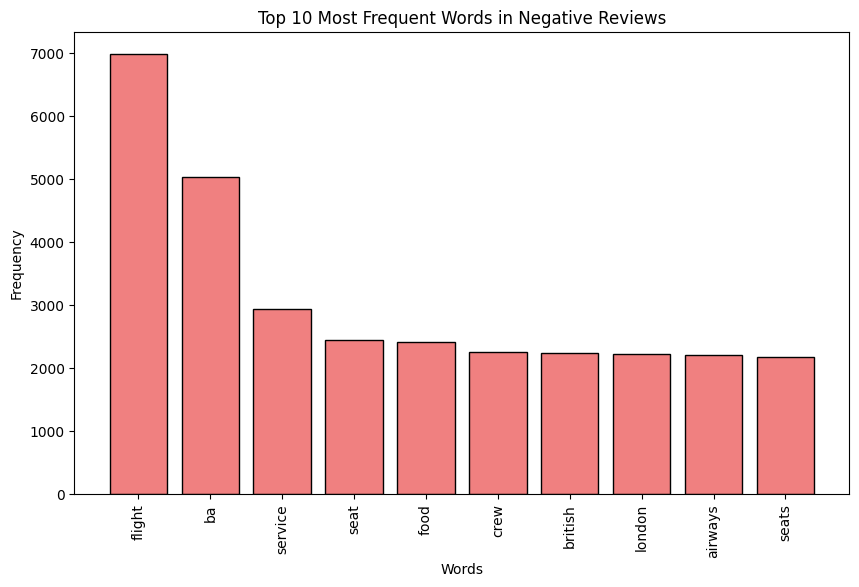

In [55]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word.isalnum()]

    return tokens

# Combine all reviews into a single list of words
all_words = []
for review in df['Review']:
    all_words.extend(preprocess_text(review))

# Count word frequencies
word_counts = Counter(all_words)

# Get the 10 most common words
most_common_words = word_counts.most_common(10)

# Separate the words and their counts for plotting
words, counts = zip(*most_common_words)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='lightcoral', edgecolor='black')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words in Negative Reviews')
plt.xticks(rotation=90)

# Save the plot to a file
plt.savefig('top_10_word.png', bbox_inches='tight')

# Show the plot
plt.show()
